In [1]:
import sys, os
PROJECT_ROOT = r"D:\bhermosi\chestxsim-project" 
SRC = os.path.join(PROJECT_ROOT, "src")
if SRC not in sys.path:
    sys.path.insert(0, SRC)

In [2]:
from chestxsim.wrappers.astra import *
from chestxsim.core import TomoGeom

GPU detected: Using CuPy with 1 device(s), current device: 0


In [3]:
geom = TomoGeom(
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,
    SDD=1800.0,
    bucky=14.47,
    step_mm=16.077,
    nprojs=60
)


In [4]:
print(geom.beam) 
print(geom.modality)
print(geom.DOD)

BeamGeom.CONE
Modality.TOMO
None


In [5]:
from chestxsim.io import RawReader
from chestxsim.projection.steps import Projection
from chestxsim.utility import plot
from pathlib import Path 

reader = RawReader()
base_path= Path(r"D:\bhermosi\chestxsim-project\examples\volumes\CT_converted")
case_id = "NODULO_S18_S20"
att_vol = reader.read( base_path/ "mus"/ case_id)

In [6]:
att_vol.metadata.voxel_size

(0.84, 0.84, 1.25)

In [7]:
tomo_op= ASTRA_Tomo(geom)

In [8]:
for attr, value in tomo_op.__dict__.items():
    print(f"- {attr}: {value}")

- geometry: TomoGeom(SDD=1800.0, DOD=None, nprojs=60, step_mm=16.077, detector_size=(4288, 4288), pixel_size=(0.1, 0.1), binning_proj=8, bucky=14.47)
- backend: Backend.GPU
- hooks: <chestxsim.wrappers.astra.ASTRAHooks object at 0x00000288450D6470>


In [9]:
input_vol = att_vol.volume[:,:,:,0]
vx_xyz = att_vol.metadata.voxel_size

projs = tomo_op.project(input_vol, vx_xyz)
projs.shape

reco_dim_xyz = (344, 86, 276)
reco_vx_xyz = (1.25, 5.00, 1.25)
backproj = tomo_op.backproject(projs, reco_dim_xyz, reco_vx_xyz)
backproj.shape

TypeError: Unsupported type <class 'tuple'>

In [10]:
geom.DOD

286.97

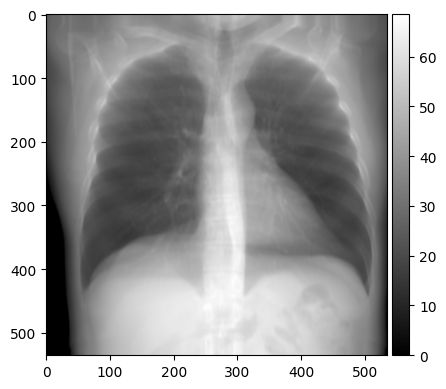

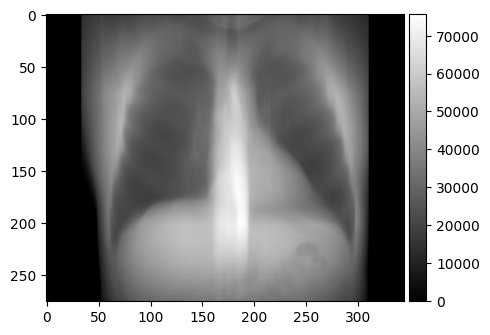

In [11]:
plot(projs[:,:,30].T.get())
plot(backproj[:,30,:].T.get())

In [12]:
geom_cbct = CTGeom(
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,
    SDD=1800.0,
    DOD=307.452,
    nprojs= 360,
    step_angle= 1, 
    init_angle=  -90
)
cbct = ASTRA_CBCT(geom_cbct)

In [13]:
geom_cbct_factory = create_geometry(
    beam= BeamGeom.CONE,
    modality= Modality.CT3D, 
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,

    SDD=1800.0,
    DOD=307.452,
    nprojs= 360,
    step_angle= 1, 
    init_angle=  -90
)

In [14]:
cbct_cpu = ASTRA_CBCT(geom_cbct_factory, Backend.CPU)

In [15]:
cbct_cpu.hooks.backend

<Backend.CPU: 'cpu'>

In [16]:
input_vol = att_vol.volume[:,:,:,0]
vx_xyz = [att_vol.metadata.voxel_size[i]*0.85 for i in range(3)]
print(input_vol.shape)
print(vx_xyz)

(512, 351, 436)
[0.714, 0.714, 1.0625]


(536, 536, 360)


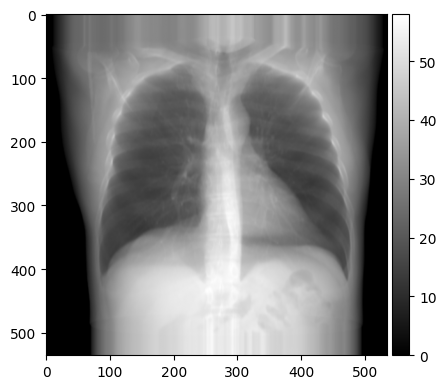

In [17]:
projs = cbct.project(input_vol, vx_xyz)
print(projs.shape)
plot(projs[:,:,90].T.get())

(512, 351, 436)


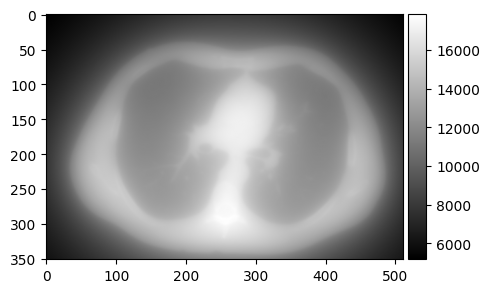

In [18]:
backproj = cbct.backproject(projs, input_vol.shape, vx_xyz)
print(backproj.shape)
plot(backproj[:,:,200].T.get())

In [19]:
# vx_size_iso = (1.0, 1.0, 1.0)
# fdk = cbct.reconstruct(
#     "FDK_CUDA",
#     projs,
#     input_vol.shape, 
#     vx_size_iso,
#     options={"FilterType": "Ram-Lak"} ) 

# plot(fdk[:,:,200].T.get()) 

In [20]:
# vx_size_iso = (1.0, 1.0, 1.0)
# sirt = cbct.reconstruct(
#     "SIRT3D_CUDA",
#     projs,
#     input_vol.shape, 
#     vx_size_iso,
#     options={"MinConstrain": "0.0"},
#     iterations = 150) 

# plot(sirt[:,:,200].T.get()) 


In [21]:
# vx_size_iso = (1.0, 1.0, 1.0)
# sirt = cbct.reconstruct(
#     "CGLS3D_CUDA",
#     projs,
#     input_vol.shape, 
#     vx_size_iso,
#     iterations = 100) 

# plot(sirt[:,:,200].T.get())

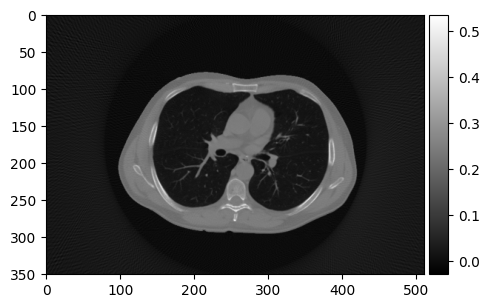

In [22]:
vx_size_iso = (1.0, 1.0, 1.0)
fdk = cbct.reconstruct(
    "FDK_CUDA",
    projs,
    input_vol.shape, 
    vx_size_iso,
    options={"FilterType": "Ram-Lak"} ) 

plot(fdk[:,:,200].T.get()) 

In [23]:
fanbeam_geom = CT2DFanGeom(
    detector_size=4288,
    pixel_size=0.1,
    binning_proj=8,
    SDD=1800.0,
    DOD=307.452,
    nprojs= 360,
    step_angle= 1, 
    init_angle=  -90
)

(360, 536)


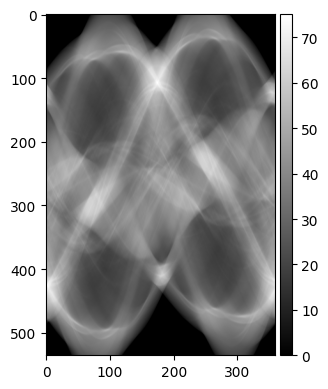

In [24]:

input_img = att_vol.volume[:,:,200,0]
px_xy = (0.85, 0.85)
fanbeam = ASTRA_FANBEAMCT(fanbeam_geom)
projs = fanbeam.project(input_img, px_xy)
print(projs.shape)
plot(projs.T.get())

In [25]:
backproj = fanbeam.backproject(projs, input_img.shape, px_xy)
fbp = fanbeam.reconstruct(
    "FBP_CUDA",
    projs,
    input_img.shape, 
    px_xy,
    options = {"FilterType": "Ram-Lak"} ) 



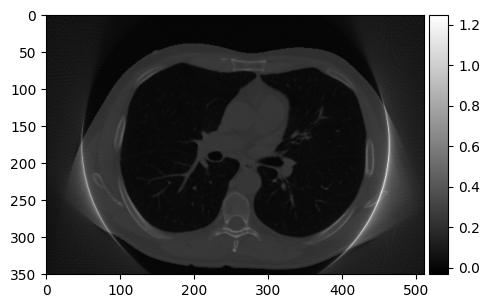

In [26]:
plot(fbp.T.get())

In [27]:
it = fanbeam.reconstruct(
    method ="SIRT_CUDA",
    sino = projs,
    reco_dim_xyz = input_img.shape, 
    reco_vx_xyz = px_xy,
    options = {'MinConstraint': 0.0},
    iterations = 1000
    )

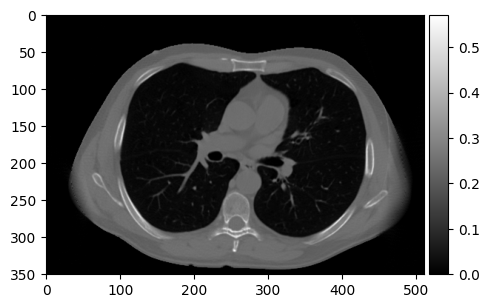

In [28]:
plot(it.T.get())